In [37]:
!pip install transformers
!pip install timm

In [63]:
import os
from transformers import AutoImageProcessor, AutoModelForObjectDetection
import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import numpy as np
from IPython.display import display, clear_output
import time

In [64]:
#Folder containing images
input_folder = "sample_images"

In [65]:
#Output folder where processed images will be saved
output_folder = "processed_images"
os.makedirs(output_folder, exist_ok=True)

# Allowed image file extensions
image_extensions = (".jpg", ".jpeg", ".png", ".bmp")

# Gets image paths from the input folder
image_paths = [
    os.path.join(input_folder, filename)
    for filename in os.listdir(input_folder)
    if filename.lower().endswith(image_extensions)
]

In [66]:
# Load the processor and model
processor = AutoImageProcessor.from_pretrained("PekingU/rtdetr_r18vd")
model = AutoModelForObjectDetection.from_pretrained("PekingU/rtdetr_r18vd")

In [67]:
def process_and_save_images(image_paths, output_dir):
    for image_path in image_paths:
        # Load and convert image to RGB
        image = Image.open(image_path).convert("RGB")

        # Preprocess the image and perform inference
        inputs = processor(images=image, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)

        # Post-process the outputs with a confidence threshold
        target_sizes = torch.tensor([image.size[::-1]])
        results = processor.post_process_object_detection(outputs, threshold=0.3, target_sizes=target_sizes)[0]

        # Create a plot to display results
        fig, ax = plt.subplots(1, figsize=(12, 9))
        ax.imshow(image)
        for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
            x, y, x2, y2 = box
            rect = patches.Rectangle((x, y), x2 - x, y2 - y, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y, f"{model.config.id2label[label.item()]}: {score:.2f}", color='red', fontsize=12)
        plt.axis('off')

        # Save the annotated image to the output folder
        output_path = os.path.join(output_dir, os.path.basename(image_path))
        plt.savefig(output_path, bbox_inches='tight')
        plt.close(fig)


In [68]:
process_and_save_images(image_paths, output_folder)

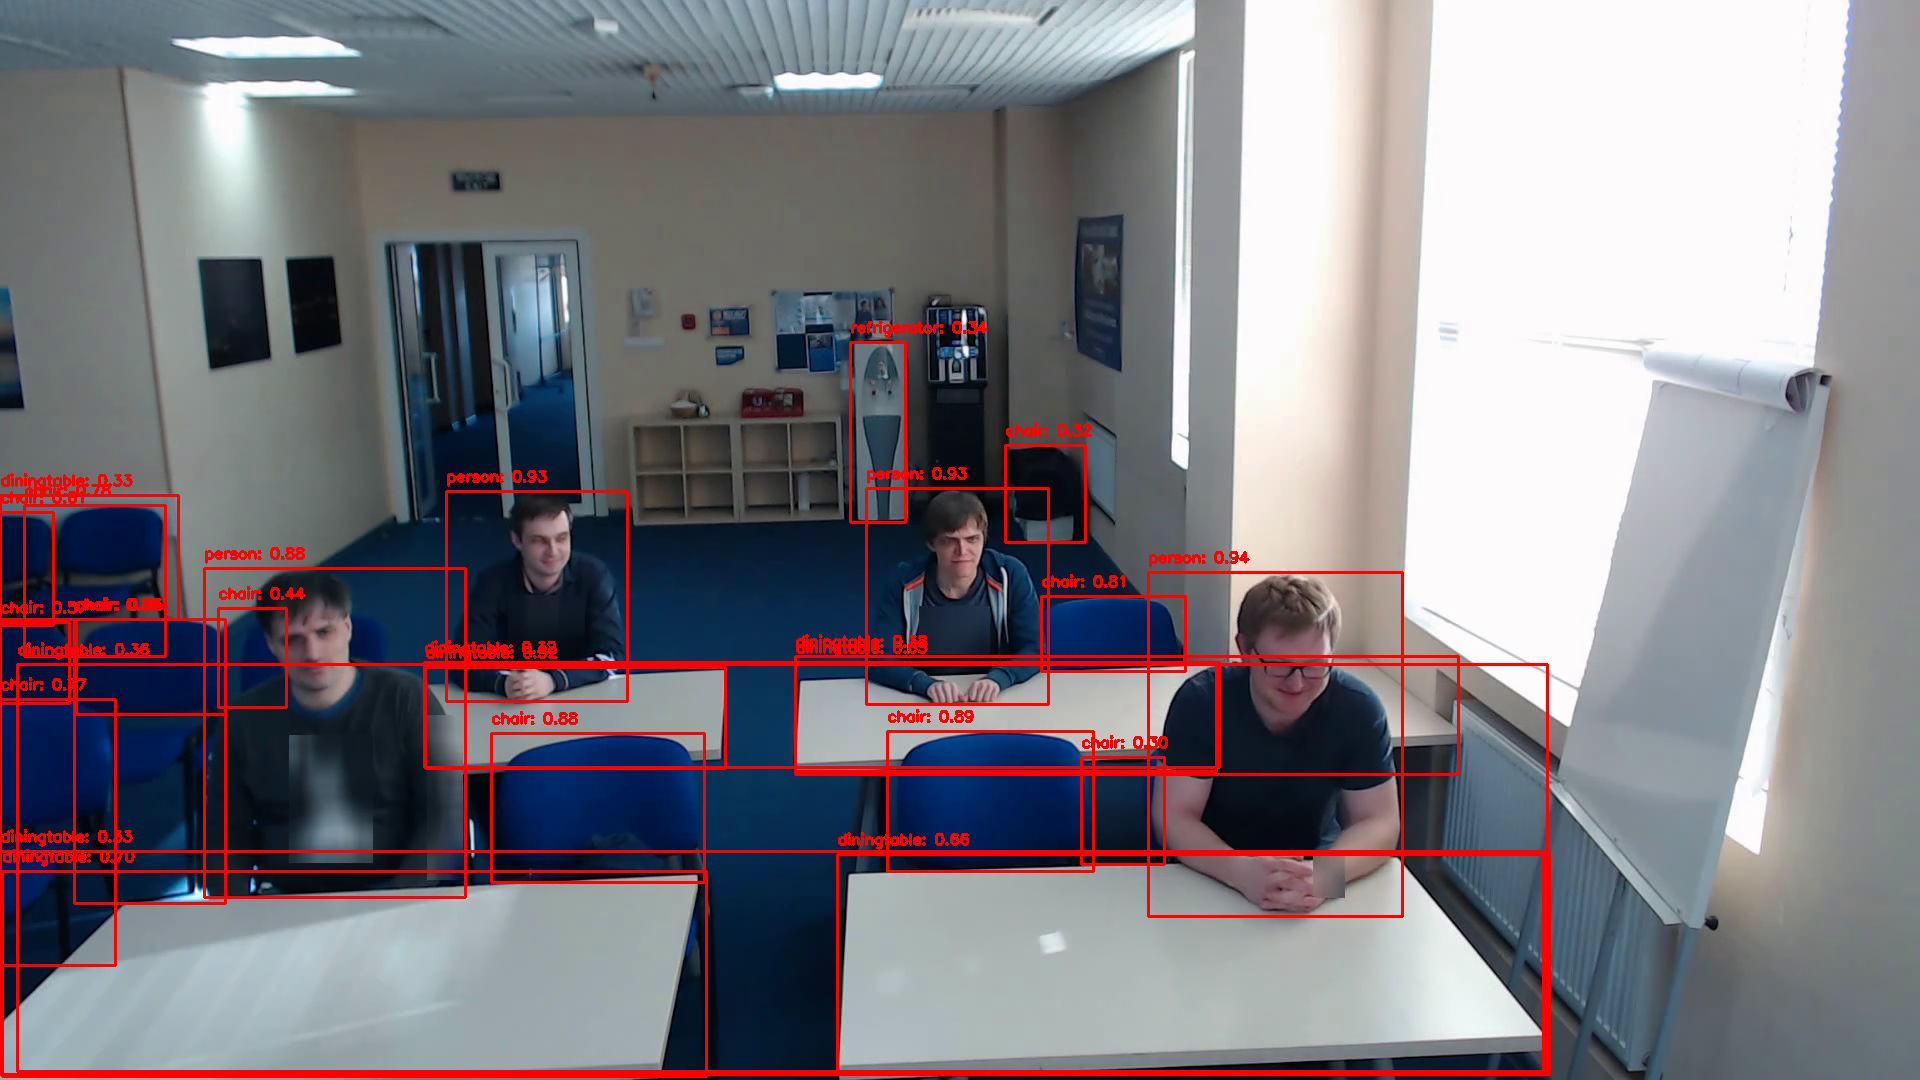

KeyboardInterrupt: 

In [69]:
# Specify your video file path
video_path = "classroom.mp4"  # Replace with your video filename

# Open the video file using OpenCV
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Could not open video file!")
    exit()

# Process the video frame-by-frame
fps_target = 30  # adjust for desired frame rate display
frame_interval = 1.0 / fps_target

while True:
    ret, frame = cap.read()
    if not ret:
        break  # End of video

    # Convert frame (BGR -> RGB) and create a PIL image
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(frame_rgb)

    # Preprocess the image and run inference
    inputs = processor(images=pil_img, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)

    # Post-process the detections with a confidence threshold
    target_sizes = torch.tensor([pil_img.size[::-1]])
    results = processor.post_process_object_detection(outputs, threshold=0.3, target_sizes=target_sizes)[0]

    # Draw bounding boxes directly on the frame using OpenCV
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        # Convert box coordinates to integers
        x, y, x2, y2 = box.int().tolist()
        cv2.rectangle(frame, (x, y), (x2, y2), color=(0, 0, 255), thickness=2)
        cv2.putText(frame, f"{model.config.id2label[label.item()]}: {score:.2f}",
                    (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Convert the annotated frame from BGR to RGB for display
    annotated_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Display the frame inline (simulate video stream)
    clear_output(wait=True)
    display(Image.fromarray(annotated_frame))
    time.sleep(frame_interval)  # control display rate

# Release video resources
cap.release()